In [3]:
# Load libraries
import numpy as np
import pandas as pd
import re
from scipy import stats
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import math
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor as rfr,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, SCORERS

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import GridSearchCV

%matplotlib inline
plt.style.use('ggplot')
from IPython.display import display
display.max_columns = None
display.max_rows = None

/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [4]:
# load data
train = pd.read_csv('../data/train_processed.csv')
test_raw = pd.read_csv('../data/test.csv')
test = pd.read_csv('../data/test_processed.csv')

In [5]:
y_log = np.log(train['SalePrice']) # Log of SalePrice
yt = stats.boxcox(train['SalePrice'], lmbda = 0.3) # Boxcox of SalePrice
X = train.drop(columns='SalePrice')
X = X.loc[:, X.columns!='HouseStyle_2.5Fin'] #HouseStyle_2.5Fin in training.csv but not in test.csv

In [32]:
# Load libraries
import numpy as np
import pandas as pd
import re
from scipy import stats
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import math
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor as rfr,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, SCORERS

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import GridSearchCV

%matplotlib inline
plt.style.use('ggplot')
from IPython.display import display
display.max_columns = None
display.max_rows = None

In [33]:
# load data
train = pd.read_csv('../data/train_processed.csv')
test_raw = pd.read_csv('../data/test.csv')
test = pd.read_csv('../data/test_processed.csv')

In [34]:
y_log = np.log(train['SalePrice']) # Log of SalePrice
yt = stats.boxcox(train['SalePrice'], lmbda = 0.3) # Boxcox of SalePrice
X = train.drop(columns='SalePrice')
X = X.loc[:, X.columns!='HouseStyle_2.5Fin'] #HouseStyle_2.5Fin in training.csv but not in test.csv

## Skewness (adjust Skewness of numeric columns)
#### 
Unnamed: 0                    int64
MSSubClass                    int64
LotFrontage                 float64
LotArea                       int64
YearBuilt                     int64
YearRemodAdd                  int64
MasVnrArea                  float64
BsmtFinSF1                  float64
BsmtFinSF2                  float64
BedroomAbvGr                  int64
KitchenAbvGr                  int64
TotRmsAbvGrd                  int64
Fireplaces                    int64
GarageYrBlt                 float64
GarageCars                  float64
GarageArea                  float64
WoodDeckSF                    int64
EnclosedPorch                 int64
3SsnPorch                     int64
ScreenPorch                   int64
PoolArea                      int64
MiscVal                       int64
IsPool                        int64 - not numerical
IsGarage                      int64 - not numerical
TotalFullBath               float64
TotalHalfBath               float64
TotalSF                     float64

In [6]:
numeric=X.loc[:, X.columns != 'IsPool']
numeric = numeric.loc[:, numeric.columns !='IsGarage']
numerical = numeric.dtypes[:27].index.to_list()
skewed = X[numerical].apply(lambda x: x.skew()).sort_values()
skewdf = pd.DataFrame({'Skew': skewed})
skewdf = skewdf[(skewdf)>0.75]
from scipy.special import boxcox1p
skewed = skewdf.index
lam = 0.15
for feat in skewed:
    X[feat] = boxcox1p(X[feat], lam)
    test[feat] = boxcox1p(test[feat], lam)
# newskewed = X[numerical].apply(lambda x: x.skew()).sort_values()

In [7]:
print(test.shape)
print(X.shape)

(1459, 229)
(1458, 229)


## Evaluate Models

In [30]:
### This function returns R2 for test and validation sets
def get_r2(model): 
    R2_train=model.score(x_tr, y_tr)
    R2_val=model.score(x_val,y_val)
    return(R2_train, R2_val)


### This function returns Average R2 for 5 fold Cross Validation tests.
def r2_cv(model, boxcox=True):
    if boxcox==True:
        y = yt
    else:
        y = y_log
    n_folds = 5
    kf = KFold(n_folds, shuffle=True, random_state=1).get_n_splits(X)
    R2= cross_val_score(model, X, y, scoring="r2", cv = kf)
    return(R2)


## OLM

### Log(SalePrice)

In [26]:
x_tr, x_val, y_tr, y_val = train_test_split(X, y_log, test_size=0.2, random_state=1)
olm = LinearRegression()

score=r2_cv(olm, boxcox=False)
print("CV Average R2: {:.4f} ({:.4f})".format(score.mean(), score.std()))

olm.fit(x_tr, y_tr)
print(f"R2 for train and test are: {get_r2(olm)}")

prediction=np.exp(olm.predict(test))
pred = pd.DataFrame(prediction, columns=['SalePrice'])
ID = test_raw[['Id']]
sub=pd.merge(ID, pred, left_on = ID.index, right_on = pred.index).drop(columns=['key_0'])
sub.to_csv('../Submissions/submission_olm_logY.csv',index=False)

CV Average R2: -124060511096666832.0000 (239232638828592288.0000)
R2 for train and test are: (0.9465768351553838, 0.8980902264781501)


### BoxCox(SalePrice)

In [27]:
x_tr, x_val, y_tr, y_val = train_test_split(X, yt, test_size=0.2, random_state=1)
olm = LinearRegression()
olm.fit(x_tr, y_tr)
print(f"R2 for train and test are: {get_r2(olm)}")

olm_score=r2_cv(olm)
print("CV Average R2: {:.4f} ({:.4f})".format(olm_score.mean(), olm_score.std()))

prediction=olm.predict(test)
prediction=inv_boxcox(prediction,0.3)
pred = pd.DataFrame(prediction, columns=['SalePrice'])
ID = test_raw[['Id']]
sub1=pd.merge(ID, pred, left_on = ID.index, right_on = pred.index).drop(columns=['key_0'])
sub1.to_csv('../Submissions/submission_olm_boxcox.csv',index=False)

R2 for train and test are: (0.9481024539916888, 0.9040675841336481)
CV Average R2: -218109852166945056.0000 (428155705833817984.0000)


- OLM does not fit all training datasets. potential outlier.

## How do the coefficients shrink?

/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9186.260559063972, tolerance: 33.00059819797645
  positive)


Text(0,0.5,'slope values')

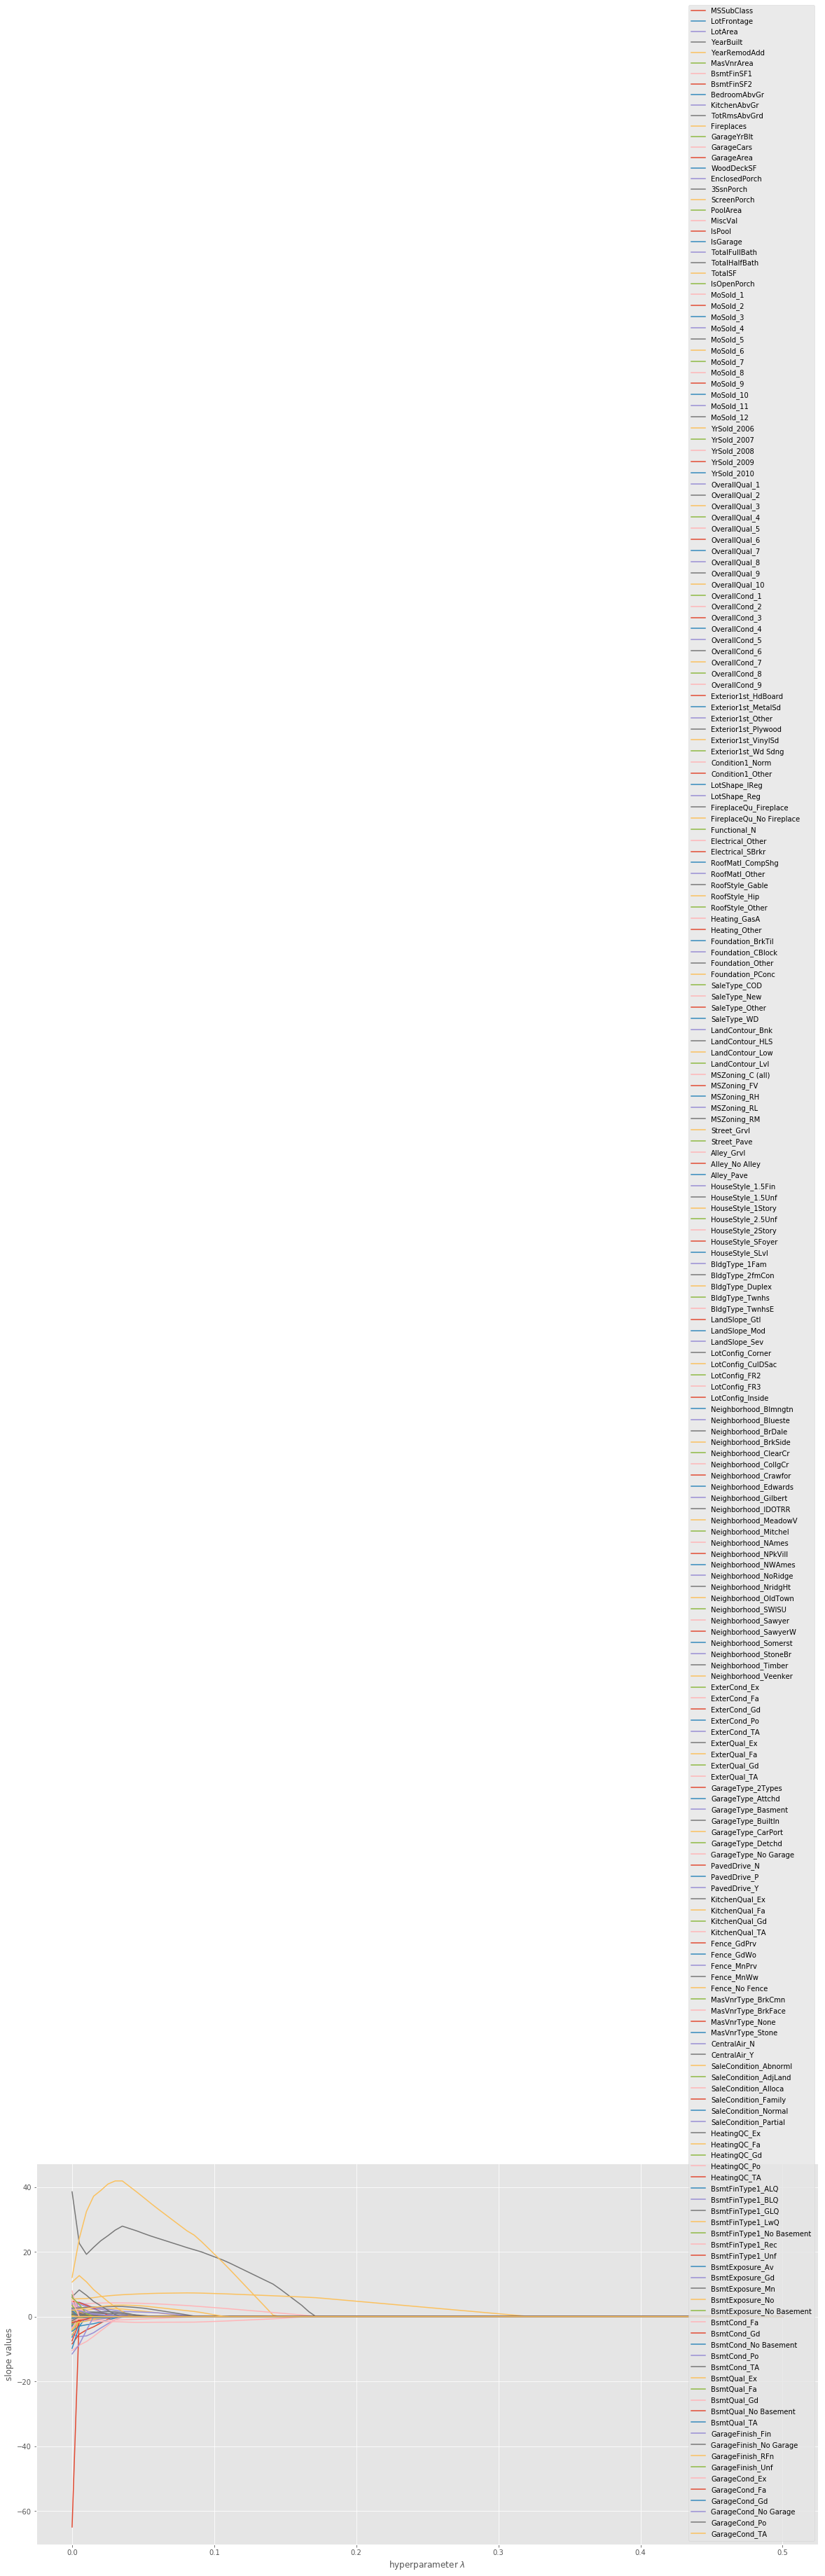

In [28]:
# how do different coefficients shrink?
from sklearn.linear_model import Lasso
lasso = Lasso(normalize=True)
alphas = np.linspace(1e-9,0.5,100)
lasso.set_params(normalize=True)
coefs  = []
scores = []
for alpha in alphas:
        lasso.set_params(alpha=alpha)
        lasso.fit(X, yt)
        coefs.append(lasso.coef_)
        scores.append(lasso.score(X, yt))
coefs = pd.DataFrame(coefs, index = alphas, columns = X.columns)  

plt.rcParams['figure.figsize'] = (20,10)
for name in coefs.columns:
    plt.plot(coefs.index, coefs[name], label=name)
plt.legend(loc=4)   
plt.xlabel(r'hyperparameter $\lambda$')
plt.ylabel(r'slope values')

## Model: Ridge 

In [11]:
from sklearn.linear_model import Ridge
ridge = Ridge(normalize=True)
score=r2_cv(ridge)
print("Ridge R2 Score (before tuning params): {:.4f} ({:.4f})".format(score.mean(), score.std()))
alphaRange = np.linspace(1e-2,1e-1,100).tolist()
params = [{'alpha':alphaRange}]
gridSearch=GridSearchCV(estimator=ridge, param_grid=params)
gridSearch.fit(X,yt)
print(f"Best Params: {gridSearch.best_params_}")
print(f"Best Score: {gridSearch.best_score_}")
ridge = gridSearch.best_estimator_
score=r2_cv(ridge)
print("[Ridge best params] CV Average R2: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Ridge R2 Score (before tuning params): 0.8928 (0.0119)
Best Params: {'alpha': 0.049090909090909095}
Best Score: 0.9176739964280575
[Ridge best params] CV Average R2: 0.9177 (0.0076)


In [12]:
prediction=ridge.predict(test)
prediction=inv_boxcox(prediction, 0.3)
pred = pd.DataFrame(prediction, columns=['SalePrice'])
ID = test_raw[['Id']]
sub1=pd.merge(ID, pred, left_on = ID.index, right_on = pred.index).drop(columns=['key_0'])
sub1.to_csv('../Submissions/pred_ridge.csv',index=False)

## Model : Lasso 

In [10]:
lasso = Lasso(normalize=True, alpha = 1e-10)
score=r2_cv(lasso)
print("Lasso R2 score (before tuning params): {:.4f} ({:.4f})".format(score.mean(), score.std()))
alphaRange = np.linspace(1e-3,1e-2,100).tolist()

params = {'alpha':alphaRange}
gridSearch=GridSearchCV(estimator=lasso, param_grid=params)
gridSearch.fit(X, yt)
print(f"Best Params: {gridSearch.best_params_}") 
print(f"Best Score: {gridSearch.best_score_}")

lasso = gridSearch.best_estimator_
score=r2_cv(lasso)
print("[Lasso best params] CV Average R2: {:.4f} ({:.4f})".format(score.mean(), score.std()))


/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7217.818236290626, tolerance: 26.837866900672438
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7142.435116483656, tolerance: 25.66515382632661
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6451.743506154694, tolerance: 25.80046626193999
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did

Lasso R2 score (before tuning params): 0.9151 (0.0077)
Best Params: {'alpha': 0.002454545454545455}
Best Score: 0.9230057683262112
[Lasso best params] CV Average R2: 0.9230 (0.0072)


In [13]:
prediction=lasso.predict(test)
prediction=inv_boxcox(prediction, 0.3)
pred = pd.DataFrame(prediction, columns=['SalePrice'])
ID = test_raw[['Id']]
sub1=pd.merge(ID, pred, left_on = ID.index, right_on = pred.index).drop(columns=['key_0'])
sub1.to_csv('../Submissions/pred_lasso.csv',index=False)


### Below are surviving features after Lasso

In [23]:
features_lasso={}
i = 0
for name in X.columns:
    features_lasso[name]=lasso.coef_[i]
    i += 1
    
features_lasso_reduced={}
for name in features_lasso:
    if features_lasso[name] > 1e-10:
        features_lasso_reduced[name]=features_lasso[name]
        
reduced_features=[]
for i in features_lasso_reduced.keys():
    reduced_features.append(i)
print(len(reduced_features))
print(reduced_features)

62
['LotArea', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'WoodDeckSF', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'TotalFullBath', 'TotalHalfBath', 'TotalSF', 'IsOpenPorch', 'MoSold_5', 'MoSold_7', 'OverallQual_7', 'OverallQual_8', 'OverallQual_9', 'OverallQual_10', 'OverallCond_7', 'OverallCond_8', 'OverallCond_9', 'Exterior1st_Other', 'Condition1_Norm', 'RoofStyle_Hip', 'Foundation_Other', 'Foundation_PConc', 'SaleType_New', 'SaleType_Other', 'MSZoning_FV', 'MSZoning_RH', 'Alley_Pave', 'HouseStyle_2Story', 'BldgType_1Fam', 'LandSlope_Mod', 'LotConfig_Corner', 'LotConfig_CulDSac', 'Neighborhood_BrkSide', 'Neighborhood_Crawfor', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Veenker', 'ExterCond_Ex', 'ExterCond_TA', 'ExterQual_Ex', 'GarageType_BuiltIn', 'PavedDrive_Y', 'KitchenQual_Ex', 'MasVnrType_Stone', 'HeatingQC_Ex', 'BsmtFinType1_GLQ', 'BsmtFinType1_No Basement', 'BsmtExposure

### Elastic Net

In [21]:
from sklearn.linear_model import ElasticNet
net = ElasticNet(normalize=True, alpha=0.001, l1_ratio=1)
score=r2_cv(net)
print("Elastic Net R2 Score (before tuning params): {:.4f} ({:.4f})".format(score.mean(), score.std()))

alphaRange=np.linspace(1e-3,1e-2,100).tolist()
l1_ratio_range=[1]
params = {'alpha':alphaRange, 'l1_ratio':l1_ratio_range}
gridSearch=GridSearchCV(estimator=net, param_grid=params)
gridSearch.fit(X, yt)

print(f"Best Params: {gridSearch.best_params_}") 
print(f"Best Score: {gridSearch.best_score_}")

net_best = gridSearch.best_estimator_
net_score=r2_cv(net_best)
print("Elastic Net R2: {:.4f} ({:.4f})".format(net_score.mean(), net_score.std()))

Elastic Net R2 Score (before tuning params): 0.9215 (0.0075)
Best Params: {'alpha': 0.002454545454545455, 'l1_ratio': 1}
Best Score: 0.9230057683262112
Elastic Net R2: 0.9230 (0.0072)


In [18]:
prediction=net_best.predict(test)
prediction=inv_boxcox(prediction, 0.3)
pred = pd.DataFrame(prediction, columns=['SalePrice'])
ID = test_raw[['Id']]
sub1=pd.merge(ID, pred, left_on = ID.index, right_on = pred.index).drop(columns=['key_0'])
sub1.to_csv('../Submissions/pred_net.csv',index=False)

## CatBoost

In [34]:
from catboost import CatBoostRegressor
catB = CatBoostRegressor(iterations=3000)
score = r2_cv(catB)
print("CatBoosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Learning rate set to 0.040112
0:	learn: 14.7624151	total: 9.07ms	remaining: 9.07s
1:	learn: 14.3920757	total: 12.1ms	remaining: 6.02s
2:	learn: 14.0291174	total: 14.5ms	remaining: 4.8s
3:	learn: 13.6874695	total: 17.2ms	remaining: 4.28s
4:	learn: 13.3676044	total: 20.3ms	remaining: 4.05s
5:	learn: 13.0131826	total: 24.2ms	remaining: 4.01s
6:	learn: 12.6940853	total: 27.3ms	remaining: 3.87s
7:	learn: 12.4276061	total: 29.6ms	remaining: 3.67s
8:	learn: 12.1236409	total: 31.8ms	remaining: 3.5s
9:	learn: 11.8270875	total: 34.1ms	remaining: 3.37s
10:	learn: 11.5546694	total: 35.7ms	remaining: 3.21s
11:	learn: 11.3200237	total: 37.9ms	remaining: 3.12s
12:	learn: 11.0895153	total: 40.2ms	remaining: 3.05s
13:	learn: 10.8518368	total: 42.6ms	remaining: 3s
14:	learn: 10.6002549	total: 45.4ms	remaining: 2.98s
15:	learn: 10.3676293	total: 48.2ms	remaining: 2.96s
16:	learn: 10.1542286	total: 52.2ms	remaining: 3.02s
17:	learn: 9.9381878	total: 54.7ms	remaining: 2.98s
18:	learn: 9.7228135	total: 56.9

201:	learn: 3.5838116	total: 562ms	remaining: 2.22s
202:	learn: 3.5786533	total: 564ms	remaining: 2.22s
203:	learn: 3.5719738	total: 568ms	remaining: 2.22s
204:	learn: 3.5653363	total: 571ms	remaining: 2.21s
205:	learn: 3.5604594	total: 574ms	remaining: 2.21s
206:	learn: 3.5527632	total: 578ms	remaining: 2.21s
207:	learn: 3.5467338	total: 581ms	remaining: 2.21s
208:	learn: 3.5404033	total: 584ms	remaining: 2.21s
209:	learn: 3.5330374	total: 587ms	remaining: 2.21s
210:	learn: 3.5300830	total: 590ms	remaining: 2.21s
211:	learn: 3.5246909	total: 593ms	remaining: 2.2s
212:	learn: 3.5216704	total: 596ms	remaining: 2.2s
213:	learn: 3.5193161	total: 598ms	remaining: 2.2s
214:	learn: 3.5146374	total: 600ms	remaining: 2.19s
215:	learn: 3.5104006	total: 603ms	remaining: 2.19s
216:	learn: 3.5050642	total: 605ms	remaining: 2.18s
217:	learn: 3.4968978	total: 607ms	remaining: 2.18s
218:	learn: 3.4914170	total: 610ms	remaining: 2.17s
219:	learn: 3.4844963	total: 612ms	remaining: 2.17s
220:	learn: 3.4

432:	learn: 2.5783200	total: 1.13s	remaining: 1.48s
433:	learn: 2.5717018	total: 1.13s	remaining: 1.48s
434:	learn: 2.5692481	total: 1.14s	remaining: 1.48s
435:	learn: 2.5653442	total: 1.14s	remaining: 1.47s
436:	learn: 2.5609716	total: 1.14s	remaining: 1.47s
437:	learn: 2.5572916	total: 1.15s	remaining: 1.47s
438:	learn: 2.5531255	total: 1.15s	remaining: 1.47s
439:	learn: 2.5485452	total: 1.15s	remaining: 1.47s
440:	learn: 2.5473784	total: 1.16s	remaining: 1.47s
441:	learn: 2.5446797	total: 1.16s	remaining: 1.46s
442:	learn: 2.5410384	total: 1.16s	remaining: 1.46s
443:	learn: 2.5381102	total: 1.16s	remaining: 1.46s
444:	learn: 2.5336125	total: 1.17s	remaining: 1.45s
445:	learn: 2.5323093	total: 1.17s	remaining: 1.45s
446:	learn: 2.5285186	total: 1.17s	remaining: 1.45s
447:	learn: 2.5281038	total: 1.17s	remaining: 1.45s
448:	learn: 2.5244904	total: 1.18s	remaining: 1.44s
449:	learn: 2.5212669	total: 1.18s	remaining: 1.44s
450:	learn: 2.5176616	total: 1.18s	remaining: 1.44s
451:	learn: 

670:	learn: 1.9288270	total: 1.69s	remaining: 831ms
671:	learn: 1.9266531	total: 1.7s	remaining: 829ms
672:	learn: 1.9248409	total: 1.7s	remaining: 827ms
673:	learn: 1.9225423	total: 1.7s	remaining: 825ms
674:	learn: 1.9186751	total: 1.71s	remaining: 822ms
675:	learn: 1.9164441	total: 1.71s	remaining: 820ms
676:	learn: 1.9138936	total: 1.71s	remaining: 818ms
677:	learn: 1.9111854	total: 1.72s	remaining: 816ms
678:	learn: 1.9081511	total: 1.72s	remaining: 814ms
679:	learn: 1.9056533	total: 1.72s	remaining: 811ms
680:	learn: 1.9030482	total: 1.73s	remaining: 808ms
681:	learn: 1.9003141	total: 1.73s	remaining: 806ms
682:	learn: 1.8998948	total: 1.73s	remaining: 803ms
683:	learn: 1.8973220	total: 1.73s	remaining: 800ms
684:	learn: 1.8957863	total: 1.73s	remaining: 798ms
685:	learn: 1.8941609	total: 1.74s	remaining: 795ms
686:	learn: 1.8917314	total: 1.74s	remaining: 793ms
687:	learn: 1.8898004	total: 1.74s	remaining: 790ms
688:	learn: 1.8863692	total: 1.75s	remaining: 788ms
689:	learn: 1.8

830:	learn: 1.5961122	total: 2.07s	remaining: 422ms
831:	learn: 1.5951339	total: 2.08s	remaining: 420ms
832:	learn: 1.5930347	total: 2.08s	remaining: 417ms
833:	learn: 1.5904759	total: 2.08s	remaining: 415ms
834:	learn: 1.5890897	total: 2.09s	remaining: 412ms
835:	learn: 1.5873074	total: 2.09s	remaining: 410ms
836:	learn: 1.5859939	total: 2.09s	remaining: 408ms
837:	learn: 1.5839814	total: 2.1s	remaining: 405ms
838:	learn: 1.5820380	total: 2.1s	remaining: 403ms
839:	learn: 1.5795601	total: 2.1s	remaining: 400ms
840:	learn: 1.5779131	total: 2.1s	remaining: 398ms
841:	learn: 1.5767327	total: 2.11s	remaining: 396ms
842:	learn: 1.5749780	total: 2.11s	remaining: 393ms
843:	learn: 1.5735029	total: 2.11s	remaining: 391ms
844:	learn: 1.5716815	total: 2.12s	remaining: 388ms
845:	learn: 1.5695069	total: 2.12s	remaining: 386ms
846:	learn: 1.5688613	total: 2.12s	remaining: 383ms
847:	learn: 1.5672780	total: 2.12s	remaining: 381ms
848:	learn: 1.5657631	total: 2.12s	remaining: 378ms
849:	learn: 1.56

38:	learn: 6.7544298	total: 94.2ms	remaining: 2.32s
39:	learn: 6.6660033	total: 97.6ms	remaining: 2.34s
40:	learn: 6.5839389	total: 103ms	remaining: 2.4s
41:	learn: 6.5035376	total: 107ms	remaining: 2.45s
42:	learn: 6.4212497	total: 111ms	remaining: 2.48s
43:	learn: 6.3587449	total: 115ms	remaining: 2.5s
44:	learn: 6.2918666	total: 119ms	remaining: 2.52s
45:	learn: 6.2229458	total: 124ms	remaining: 2.56s
46:	learn: 6.1572638	total: 128ms	remaining: 2.59s
47:	learn: 6.0874989	total: 131ms	remaining: 2.6s
48:	learn: 6.0270806	total: 135ms	remaining: 2.62s
49:	learn: 5.9617021	total: 138ms	remaining: 2.62s
50:	learn: 5.9074244	total: 141ms	remaining: 2.62s
51:	learn: 5.8418697	total: 144ms	remaining: 2.62s
52:	learn: 5.7893270	total: 146ms	remaining: 2.6s
53:	learn: 5.7372880	total: 148ms	remaining: 2.59s
54:	learn: 5.6877122	total: 150ms	remaining: 2.58s
55:	learn: 5.6380623	total: 153ms	remaining: 2.57s
56:	learn: 5.5837750	total: 155ms	remaining: 2.56s
57:	learn: 5.5471458	total: 158ms

251:	learn: 3.1741083	total: 668ms	remaining: 1.98s
252:	learn: 3.1706618	total: 672ms	remaining: 1.98s
253:	learn: 3.1671203	total: 677ms	remaining: 1.99s
254:	learn: 3.1616287	total: 681ms	remaining: 1.99s
255:	learn: 3.1545491	total: 684ms	remaining: 1.99s
256:	learn: 3.1475156	total: 689ms	remaining: 1.99s
257:	learn: 3.1408551	total: 692ms	remaining: 1.99s
258:	learn: 3.1352646	total: 695ms	remaining: 1.99s
259:	learn: 3.1310405	total: 698ms	remaining: 1.99s
260:	learn: 3.1236200	total: 702ms	remaining: 1.99s
261:	learn: 3.1211670	total: 704ms	remaining: 1.98s
262:	learn: 3.1137972	total: 707ms	remaining: 1.98s
263:	learn: 3.1110784	total: 709ms	remaining: 1.98s
264:	learn: 3.1086401	total: 711ms	remaining: 1.97s
265:	learn: 3.1045488	total: 713ms	remaining: 1.97s
266:	learn: 3.1003007	total: 716ms	remaining: 1.96s
267:	learn: 3.0935725	total: 718ms	remaining: 1.96s
268:	learn: 3.0885355	total: 720ms	remaining: 1.96s
269:	learn: 3.0829690	total: 723ms	remaining: 1.95s
270:	learn: 

476:	learn: 2.3256476	total: 1.24s	remaining: 1.36s
477:	learn: 2.3248048	total: 1.24s	remaining: 1.35s
478:	learn: 2.3208150	total: 1.24s	remaining: 1.35s
479:	learn: 2.3155143	total: 1.25s	remaining: 1.35s
480:	learn: 2.3152444	total: 1.25s	remaining: 1.35s
481:	learn: 2.3117368	total: 1.25s	remaining: 1.35s
482:	learn: 2.3085435	total: 1.26s	remaining: 1.34s
483:	learn: 2.3059634	total: 1.26s	remaining: 1.34s
484:	learn: 2.3026359	total: 1.26s	remaining: 1.34s
485:	learn: 2.3019738	total: 1.26s	remaining: 1.34s
486:	learn: 2.3002246	total: 1.27s	remaining: 1.33s
487:	learn: 2.2977691	total: 1.27s	remaining: 1.33s
488:	learn: 2.2921496	total: 1.27s	remaining: 1.33s
489:	learn: 2.2888148	total: 1.27s	remaining: 1.33s
490:	learn: 2.2865586	total: 1.28s	remaining: 1.32s
491:	learn: 2.2862480	total: 1.28s	remaining: 1.32s
492:	learn: 2.2816403	total: 1.28s	remaining: 1.32s
493:	learn: 2.2796752	total: 1.28s	remaining: 1.31s
494:	learn: 2.2783972	total: 1.29s	remaining: 1.31s
495:	learn: 

636:	learn: 1.9128843	total: 1.61s	remaining: 921ms
637:	learn: 1.9127427	total: 1.62s	remaining: 919ms
638:	learn: 1.9108333	total: 1.62s	remaining: 917ms
639:	learn: 1.9083290	total: 1.63s	remaining: 915ms
640:	learn: 1.9069739	total: 1.63s	remaining: 912ms
641:	learn: 1.9043899	total: 1.63s	remaining: 910ms
642:	learn: 1.9003978	total: 1.64s	remaining: 908ms
643:	learn: 1.8974313	total: 1.64s	remaining: 906ms
644:	learn: 1.8952874	total: 1.64s	remaining: 903ms
645:	learn: 1.8927828	total: 1.64s	remaining: 900ms
646:	learn: 1.8905498	total: 1.65s	remaining: 898ms
647:	learn: 1.8882541	total: 1.65s	remaining: 895ms
648:	learn: 1.8865451	total: 1.65s	remaining: 892ms
649:	learn: 1.8833031	total: 1.65s	remaining: 889ms
650:	learn: 1.8831836	total: 1.65s	remaining: 887ms
651:	learn: 1.8813264	total: 1.66s	remaining: 884ms
652:	learn: 1.8797441	total: 1.66s	remaining: 881ms
653:	learn: 1.8772966	total: 1.66s	remaining: 879ms
654:	learn: 1.8759898	total: 1.66s	remaining: 876ms
655:	learn: 

862:	learn: 1.4740218	total: 2.18s	remaining: 347ms
863:	learn: 1.4722219	total: 2.19s	remaining: 345ms
864:	learn: 1.4708830	total: 2.19s	remaining: 342ms
865:	learn: 1.4700714	total: 2.2s	remaining: 340ms
866:	learn: 1.4683185	total: 2.2s	remaining: 338ms
867:	learn: 1.4665254	total: 2.2s	remaining: 335ms
868:	learn: 1.4650401	total: 2.21s	remaining: 333ms
869:	learn: 1.4638864	total: 2.21s	remaining: 330ms
870:	learn: 1.4618592	total: 2.21s	remaining: 328ms
871:	learn: 1.4597012	total: 2.21s	remaining: 325ms
872:	learn: 1.4574566	total: 2.22s	remaining: 323ms
873:	learn: 1.4558524	total: 2.22s	remaining: 320ms
874:	learn: 1.4529855	total: 2.22s	remaining: 317ms
875:	learn: 1.4506426	total: 2.22s	remaining: 315ms
876:	learn: 1.4494833	total: 2.23s	remaining: 312ms
877:	learn: 1.4472699	total: 2.23s	remaining: 310ms
878:	learn: 1.4472174	total: 2.23s	remaining: 307ms
879:	learn: 1.4450225	total: 2.23s	remaining: 305ms
880:	learn: 1.4445917	total: 2.23s	remaining: 302ms
881:	learn: 1.4

70:	learn: 5.1055228	total: 188ms	remaining: 2.46s
71:	learn: 5.0705972	total: 191ms	remaining: 2.46s
72:	learn: 5.0353447	total: 194ms	remaining: 2.47s
73:	learn: 5.0064263	total: 198ms	remaining: 2.47s
74:	learn: 4.9787596	total: 201ms	remaining: 2.48s
75:	learn: 4.9492397	total: 204ms	remaining: 2.48s
76:	learn: 4.9275560	total: 207ms	remaining: 2.48s
77:	learn: 4.9003772	total: 210ms	remaining: 2.49s
78:	learn: 4.8754523	total: 214ms	remaining: 2.49s
79:	learn: 4.8538865	total: 216ms	remaining: 2.49s
80:	learn: 4.8242938	total: 220ms	remaining: 2.5s
81:	learn: 4.8033856	total: 224ms	remaining: 2.51s
82:	learn: 4.7767227	total: 227ms	remaining: 2.51s
83:	learn: 4.7471430	total: 231ms	remaining: 2.51s
84:	learn: 4.7248286	total: 234ms	remaining: 2.52s
85:	learn: 4.6997303	total: 237ms	remaining: 2.52s
86:	learn: 4.6725900	total: 240ms	remaining: 2.52s
87:	learn: 4.6484278	total: 244ms	remaining: 2.52s
88:	learn: 4.6221532	total: 247ms	remaining: 2.52s
89:	learn: 4.6023908	total: 250m

302:	learn: 2.9037231	total: 757ms	remaining: 1.74s
303:	learn: 2.8983549	total: 760ms	remaining: 1.74s
304:	learn: 2.8916550	total: 763ms	remaining: 1.74s
305:	learn: 2.8863335	total: 767ms	remaining: 1.74s
306:	learn: 2.8812419	total: 770ms	remaining: 1.74s
307:	learn: 2.8802915	total: 773ms	remaining: 1.74s
308:	learn: 2.8755251	total: 776ms	remaining: 1.74s
309:	learn: 2.8702060	total: 779ms	remaining: 1.73s
310:	learn: 2.8681152	total: 783ms	remaining: 1.73s
311:	learn: 2.8633870	total: 785ms	remaining: 1.73s
312:	learn: 2.8613833	total: 787ms	remaining: 1.73s
313:	learn: 2.8566283	total: 789ms	remaining: 1.72s
314:	learn: 2.8501062	total: 792ms	remaining: 1.72s
315:	learn: 2.8458151	total: 795ms	remaining: 1.72s
316:	learn: 2.8417355	total: 797ms	remaining: 1.72s
317:	learn: 2.8394465	total: 799ms	remaining: 1.71s
318:	learn: 2.8337638	total: 802ms	remaining: 1.71s
319:	learn: 2.8291270	total: 804ms	remaining: 1.71s
320:	learn: 2.8216027	total: 806ms	remaining: 1.71s
321:	learn: 

539:	learn: 2.0867155	total: 1.32s	remaining: 1.13s
540:	learn: 2.0835861	total: 1.32s	remaining: 1.12s
541:	learn: 2.0799776	total: 1.33s	remaining: 1.12s
542:	learn: 2.0778664	total: 1.33s	remaining: 1.12s
543:	learn: 2.0750162	total: 1.33s	remaining: 1.12s
544:	learn: 2.0719416	total: 1.34s	remaining: 1.12s
545:	learn: 2.0688284	total: 1.34s	remaining: 1.11s
546:	learn: 2.0666733	total: 1.34s	remaining: 1.11s
547:	learn: 2.0646617	total: 1.35s	remaining: 1.11s
548:	learn: 2.0608316	total: 1.35s	remaining: 1.11s
549:	learn: 2.0579420	total: 1.35s	remaining: 1.11s
550:	learn: 2.0574632	total: 1.35s	remaining: 1.1s
551:	learn: 2.0530356	total: 1.36s	remaining: 1.1s
552:	learn: 2.0525507	total: 1.36s	remaining: 1.1s
553:	learn: 2.0499253	total: 1.36s	remaining: 1.1s
554:	learn: 2.0482985	total: 1.36s	remaining: 1.09s
555:	learn: 2.0456490	total: 1.37s	remaining: 1.09s
556:	learn: 2.0427783	total: 1.37s	remaining: 1.09s
557:	learn: 2.0424864	total: 1.37s	remaining: 1.08s
558:	learn: 2.04

702:	learn: 1.7212313	total: 1.7s	remaining: 719ms
703:	learn: 1.7210417	total: 1.71s	remaining: 717ms
704:	learn: 1.7192663	total: 1.71s	remaining: 715ms
705:	learn: 1.7172272	total: 1.71s	remaining: 713ms
706:	learn: 1.7149989	total: 1.72s	remaining: 711ms
707:	learn: 1.7138941	total: 1.72s	remaining: 709ms
708:	learn: 1.7114137	total: 1.72s	remaining: 707ms
709:	learn: 1.7101810	total: 1.73s	remaining: 705ms
710:	learn: 1.7075889	total: 1.73s	remaining: 702ms
711:	learn: 1.7055689	total: 1.73s	remaining: 700ms
712:	learn: 1.7038792	total: 1.73s	remaining: 698ms
713:	learn: 1.7024307	total: 1.74s	remaining: 695ms
714:	learn: 1.7007303	total: 1.74s	remaining: 693ms
715:	learn: 1.6991679	total: 1.74s	remaining: 690ms
716:	learn: 1.6979250	total: 1.74s	remaining: 688ms
717:	learn: 1.6950900	total: 1.74s	remaining: 685ms
718:	learn: 1.6912651	total: 1.75s	remaining: 683ms
719:	learn: 1.6897290	total: 1.75s	remaining: 680ms
720:	learn: 1.6875718	total: 1.75s	remaining: 677ms
721:	learn: 1

866:	learn: 1.4400632	total: 2.08s	remaining: 320ms
867:	learn: 1.4384485	total: 2.09s	remaining: 317ms
868:	learn: 1.4366681	total: 2.09s	remaining: 315ms
869:	learn: 1.4357808	total: 2.09s	remaining: 313ms
870:	learn: 1.4342629	total: 2.1s	remaining: 311ms
871:	learn: 1.4316922	total: 2.1s	remaining: 308ms
872:	learn: 1.4309695	total: 2.1s	remaining: 306ms
873:	learn: 1.4284253	total: 2.11s	remaining: 304ms
874:	learn: 1.4271178	total: 2.11s	remaining: 301ms
875:	learn: 1.4258308	total: 2.11s	remaining: 299ms
876:	learn: 1.4240793	total: 2.11s	remaining: 296ms
877:	learn: 1.4233688	total: 2.12s	remaining: 294ms
878:	learn: 1.4219948	total: 2.12s	remaining: 292ms
879:	learn: 1.4204444	total: 2.12s	remaining: 289ms
880:	learn: 1.4193283	total: 2.12s	remaining: 287ms
881:	learn: 1.4176072	total: 2.12s	remaining: 284ms
882:	learn: 1.4155366	total: 2.13s	remaining: 282ms
883:	learn: 1.4137583	total: 2.13s	remaining: 279ms
884:	learn: 1.4125582	total: 2.13s	remaining: 277ms
885:	learn: 1.4

87:	learn: 4.8420277	total: 206ms	remaining: 2.14s
88:	learn: 4.8214966	total: 209ms	remaining: 2.14s
89:	learn: 4.8000095	total: 213ms	remaining: 2.15s
90:	learn: 4.7761419	total: 216ms	remaining: 2.16s
91:	learn: 4.7588355	total: 220ms	remaining: 2.17s
92:	learn: 4.7404176	total: 224ms	remaining: 2.18s
93:	learn: 4.7231721	total: 227ms	remaining: 2.18s
94:	learn: 4.7058108	total: 230ms	remaining: 2.19s
95:	learn: 4.6873456	total: 234ms	remaining: 2.2s
96:	learn: 4.6687965	total: 236ms	remaining: 2.2s
97:	learn: 4.6524373	total: 238ms	remaining: 2.19s
98:	learn: 4.6374008	total: 241ms	remaining: 2.19s
99:	learn: 4.6211937	total: 244ms	remaining: 2.19s
100:	learn: 4.6038916	total: 246ms	remaining: 2.19s
101:	learn: 4.5943279	total: 248ms	remaining: 2.18s
102:	learn: 4.5853326	total: 250ms	remaining: 2.18s
103:	learn: 4.5669527	total: 253ms	remaining: 2.17s
104:	learn: 4.5499379	total: 255ms	remaining: 2.17s
105:	learn: 4.5319740	total: 257ms	remaining: 2.17s
106:	learn: 4.5148780	total

247:	learn: 3.3743455	total: 589ms	remaining: 1.79s
248:	learn: 3.3723047	total: 593ms	remaining: 1.79s
249:	learn: 3.3665758	total: 596ms	remaining: 1.79s
250:	learn: 3.3626959	total: 600ms	remaining: 1.79s
251:	learn: 3.3572290	total: 604ms	remaining: 1.79s
252:	learn: 3.3514564	total: 607ms	remaining: 1.79s
253:	learn: 3.3479700	total: 610ms	remaining: 1.79s
254:	learn: 3.3406134	total: 614ms	remaining: 1.79s
255:	learn: 3.3384773	total: 616ms	remaining: 1.79s
256:	learn: 3.3324169	total: 619ms	remaining: 1.79s
257:	learn: 3.3296187	total: 621ms	remaining: 1.79s
258:	learn: 3.3271212	total: 623ms	remaining: 1.78s
259:	learn: 3.3249067	total: 625ms	remaining: 1.78s
260:	learn: 3.3161138	total: 628ms	remaining: 1.78s
261:	learn: 3.3143156	total: 630ms	remaining: 1.77s
262:	learn: 3.3093622	total: 632ms	remaining: 1.77s
263:	learn: 3.3029488	total: 635ms	remaining: 1.77s
264:	learn: 3.2966752	total: 637ms	remaining: 1.77s
265:	learn: 3.2918970	total: 639ms	remaining: 1.76s
266:	learn: 

466:	learn: 2.4914092	total: 1.15s	remaining: 1.31s
467:	learn: 2.4872821	total: 1.15s	remaining: 1.31s
468:	learn: 2.4850695	total: 1.15s	remaining: 1.31s
469:	learn: 2.4818319	total: 1.16s	remaining: 1.31s
470:	learn: 2.4773306	total: 1.16s	remaining: 1.3s
471:	learn: 2.4759036	total: 1.17s	remaining: 1.3s
472:	learn: 2.4714518	total: 1.17s	remaining: 1.3s
473:	learn: 2.4696135	total: 1.17s	remaining: 1.3s
474:	learn: 2.4666894	total: 1.18s	remaining: 1.3s
475:	learn: 2.4608293	total: 1.18s	remaining: 1.3s
476:	learn: 2.4576972	total: 1.18s	remaining: 1.29s
477:	learn: 2.4543218	total: 1.18s	remaining: 1.29s
478:	learn: 2.4503394	total: 1.19s	remaining: 1.29s
479:	learn: 2.4469718	total: 1.19s	remaining: 1.29s
480:	learn: 2.4440308	total: 1.19s	remaining: 1.29s
481:	learn: 2.4386136	total: 1.19s	remaining: 1.28s
482:	learn: 2.4356394	total: 1.2s	remaining: 1.28s
483:	learn: 2.4308363	total: 1.2s	remaining: 1.28s
484:	learn: 2.4276447	total: 1.2s	remaining: 1.28s
485:	learn: 2.4251436

689:	learn: 1.8434621	total: 1.71s	remaining: 770ms
690:	learn: 1.8414588	total: 1.72s	remaining: 768ms
691:	learn: 1.8389736	total: 1.72s	remaining: 766ms
692:	learn: 1.8364840	total: 1.72s	remaining: 764ms
693:	learn: 1.8334959	total: 1.73s	remaining: 762ms
694:	learn: 1.8302180	total: 1.73s	remaining: 760ms
695:	learn: 1.8279042	total: 1.73s	remaining: 758ms
696:	learn: 1.8260682	total: 1.74s	remaining: 756ms
697:	learn: 1.8219466	total: 1.74s	remaining: 754ms
698:	learn: 1.8193605	total: 1.74s	remaining: 751ms
699:	learn: 1.8175683	total: 1.75s	remaining: 749ms
700:	learn: 1.8153166	total: 1.75s	remaining: 746ms
701:	learn: 1.8132277	total: 1.75s	remaining: 744ms
702:	learn: 1.8119415	total: 1.75s	remaining: 741ms
703:	learn: 1.8095906	total: 1.76s	remaining: 739ms
704:	learn: 1.8076577	total: 1.76s	remaining: 736ms
705:	learn: 1.8040679	total: 1.76s	remaining: 734ms
706:	learn: 1.8031864	total: 1.76s	remaining: 731ms
707:	learn: 1.8014502	total: 1.77s	remaining: 728ms
708:	learn: 

903:	learn: 1.4297425	total: 2.29s	remaining: 243ms
904:	learn: 1.4277237	total: 2.29s	remaining: 240ms
905:	learn: 1.4261591	total: 2.29s	remaining: 238ms
906:	learn: 1.4252483	total: 2.3s	remaining: 236ms
907:	learn: 1.4233063	total: 2.3s	remaining: 233ms
908:	learn: 1.4227041	total: 2.31s	remaining: 231ms
909:	learn: 1.4196009	total: 2.31s	remaining: 228ms
910:	learn: 1.4182317	total: 2.31s	remaining: 226ms
911:	learn: 1.4160299	total: 2.31s	remaining: 223ms
912:	learn: 1.4139832	total: 2.32s	remaining: 221ms
913:	learn: 1.4125959	total: 2.32s	remaining: 218ms
914:	learn: 1.4104586	total: 2.32s	remaining: 216ms
915:	learn: 1.4092573	total: 2.33s	remaining: 213ms
916:	learn: 1.4090704	total: 2.33s	remaining: 211ms
917:	learn: 1.4086187	total: 2.33s	remaining: 208ms
918:	learn: 1.4063993	total: 2.33s	remaining: 206ms
919:	learn: 1.4048873	total: 2.34s	remaining: 203ms
920:	learn: 1.4031687	total: 2.34s	remaining: 201ms
921:	learn: 1.4011754	total: 2.34s	remaining: 198ms
922:	learn: 1.

87:	learn: 4.6705636	total: 251ms	remaining: 2.6s
88:	learn: 4.6486018	total: 254ms	remaining: 2.6s
89:	learn: 4.6325376	total: 258ms	remaining: 2.61s
90:	learn: 4.6113802	total: 262ms	remaining: 2.62s
91:	learn: 4.5938998	total: 266ms	remaining: 2.62s
92:	learn: 4.5729456	total: 270ms	remaining: 2.63s
93:	learn: 4.5558186	total: 273ms	remaining: 2.63s
94:	learn: 4.5396551	total: 276ms	remaining: 2.63s
95:	learn: 4.5251563	total: 280ms	remaining: 2.63s
96:	learn: 4.5103141	total: 282ms	remaining: 2.63s
97:	learn: 4.4941455	total: 285ms	remaining: 2.62s
98:	learn: 4.4810013	total: 288ms	remaining: 2.62s
99:	learn: 4.4649701	total: 291ms	remaining: 2.61s
100:	learn: 4.4487582	total: 294ms	remaining: 2.62s
101:	learn: 4.4296855	total: 296ms	remaining: 2.61s
102:	learn: 4.4088883	total: 299ms	remaining: 2.6s
103:	learn: 4.3951301	total: 302ms	remaining: 2.6s
104:	learn: 4.3815382	total: 304ms	remaining: 2.59s
105:	learn: 4.3694719	total: 307ms	remaining: 2.59s
106:	learn: 4.3593197	total: 

283:	learn: 3.0850014	total: 822ms	remaining: 2.07s
284:	learn: 3.0796602	total: 826ms	remaining: 2.07s
285:	learn: 3.0771429	total: 830ms	remaining: 2.07s
286:	learn: 3.0751640	total: 834ms	remaining: 2.07s
287:	learn: 3.0698482	total: 839ms	remaining: 2.07s
288:	learn: 3.0628285	total: 842ms	remaining: 2.07s
289:	learn: 3.0592744	total: 846ms	remaining: 2.07s
290:	learn: 3.0516142	total: 850ms	remaining: 2.07s
291:	learn: 3.0472218	total: 853ms	remaining: 2.07s
292:	learn: 3.0411624	total: 857ms	remaining: 2.07s
293:	learn: 3.0384081	total: 860ms	remaining: 2.06s
294:	learn: 3.0346903	total: 862ms	remaining: 2.06s
295:	learn: 3.0270298	total: 865ms	remaining: 2.06s
296:	learn: 3.0226968	total: 867ms	remaining: 2.05s
297:	learn: 3.0201730	total: 871ms	remaining: 2.05s
298:	learn: 3.0149027	total: 874ms	remaining: 2.05s
299:	learn: 3.0131633	total: 876ms	remaining: 2.04s
300:	learn: 3.0078463	total: 879ms	remaining: 2.04s
301:	learn: 3.0038346	total: 882ms	remaining: 2.04s
302:	learn: 

470:	learn: 2.3535078	total: 1.4s	remaining: 1.57s
471:	learn: 2.3489937	total: 1.4s	remaining: 1.56s
472:	learn: 2.3455697	total: 1.4s	remaining: 1.56s
473:	learn: 2.3432139	total: 1.41s	remaining: 1.56s
474:	learn: 2.3404422	total: 1.41s	remaining: 1.56s
475:	learn: 2.3379374	total: 1.42s	remaining: 1.56s
476:	learn: 2.3342454	total: 1.42s	remaining: 1.56s
477:	learn: 2.3324348	total: 1.42s	remaining: 1.55s
478:	learn: 2.3302114	total: 1.43s	remaining: 1.55s
479:	learn: 2.3283077	total: 1.43s	remaining: 1.55s
480:	learn: 2.3274711	total: 1.44s	remaining: 1.55s
481:	learn: 2.3243865	total: 1.44s	remaining: 1.55s
482:	learn: 2.3224709	total: 1.44s	remaining: 1.54s
483:	learn: 2.3187929	total: 1.45s	remaining: 1.54s
484:	learn: 2.3170905	total: 1.45s	remaining: 1.54s
485:	learn: 2.3164092	total: 1.45s	remaining: 1.54s
486:	learn: 2.3140228	total: 1.46s	remaining: 1.53s
487:	learn: 2.3112985	total: 1.46s	remaining: 1.53s
488:	learn: 2.3079573	total: 1.46s	remaining: 1.53s
489:	learn: 2.3

656:	learn: 1.8464323	total: 1.97s	remaining: 1.03s
657:	learn: 1.8447939	total: 1.97s	remaining: 1.02s
658:	learn: 1.8429996	total: 1.98s	remaining: 1.02s
659:	learn: 1.8413595	total: 1.98s	remaining: 1.02s
660:	learn: 1.8400240	total: 1.99s	remaining: 1.02s
661:	learn: 1.8386964	total: 1.99s	remaining: 1.02s
662:	learn: 1.8360464	total: 2s	remaining: 1.01s
663:	learn: 1.8334723	total: 2s	remaining: 1.01s
664:	learn: 1.8311111	total: 2s	remaining: 1.01s
665:	learn: 1.8293598	total: 2s	remaining: 1s
666:	learn: 1.8281326	total: 2.01s	remaining: 1s
667:	learn: 1.8267093	total: 2.01s	remaining: 999ms
668:	learn: 1.8255474	total: 2.01s	remaining: 996ms
669:	learn: 1.8233524	total: 2.02s	remaining: 994ms
670:	learn: 1.8214839	total: 2.02s	remaining: 991ms
671:	learn: 1.8199537	total: 2.03s	remaining: 989ms
672:	learn: 1.8177245	total: 2.03s	remaining: 986ms
673:	learn: 1.8166494	total: 2.03s	remaining: 984ms
674:	learn: 1.8134299	total: 2.04s	remaining: 981ms
675:	learn: 1.8113377	total: 2

824:	learn: 1.5176424	total: 2.54s	remaining: 539ms
825:	learn: 1.5155332	total: 2.55s	remaining: 537ms
826:	learn: 1.5142177	total: 2.55s	remaining: 534ms
827:	learn: 1.5120957	total: 2.56s	remaining: 531ms
828:	learn: 1.5100512	total: 2.56s	remaining: 528ms
829:	learn: 1.5079775	total: 2.56s	remaining: 525ms
830:	learn: 1.5057255	total: 2.57s	remaining: 522ms
831:	learn: 1.5036145	total: 2.57s	remaining: 519ms
832:	learn: 1.5023831	total: 2.57s	remaining: 516ms
833:	learn: 1.5000935	total: 2.58s	remaining: 513ms
834:	learn: 1.4987940	total: 2.58s	remaining: 510ms
835:	learn: 1.4961814	total: 2.58s	remaining: 507ms
836:	learn: 1.4944628	total: 2.59s	remaining: 504ms
837:	learn: 1.4920473	total: 2.59s	remaining: 501ms
838:	learn: 1.4915019	total: 2.6s	remaining: 498ms
839:	learn: 1.4896638	total: 2.6s	remaining: 495ms
840:	learn: 1.4874041	total: 2.6s	remaining: 492ms
841:	learn: 1.4863327	total: 2.6s	remaining: 489ms
842:	learn: 1.4851625	total: 2.61s	remaining: 486ms
843:	learn: 1.48

In [45]:
catB.fit(X,yt)
print(f"R2 for Train, Test are: {get_r2(catB)}")

Learning rate set to 0.04174
0:	learn: 14.6347953	total: 4.64ms	remaining: 4.64s
1:	learn: 14.2225054	total: 8.37ms	remaining: 4.18s
2:	learn: 13.8429863	total: 11.9ms	remaining: 3.94s
3:	learn: 13.4610776	total: 15.6ms	remaining: 3.88s
4:	learn: 13.1356316	total: 19.1ms	remaining: 3.8s
5:	learn: 12.7754923	total: 22.6ms	remaining: 3.74s
6:	learn: 12.4288031	total: 25.9ms	remaining: 3.68s
7:	learn: 12.1099453	total: 29.8ms	remaining: 3.69s
8:	learn: 11.8161507	total: 35.9ms	remaining: 3.95s
9:	learn: 11.5182511	total: 40.3ms	remaining: 3.99s
10:	learn: 11.2190793	total: 45.1ms	remaining: 4.06s
11:	learn: 10.9605088	total: 49.4ms	remaining: 4.07s
12:	learn: 10.6892330	total: 52.7ms	remaining: 4s
13:	learn: 10.4520800	total: 55.9ms	remaining: 3.94s
14:	learn: 10.2291529	total: 58.8ms	remaining: 3.86s
15:	learn: 9.9840030	total: 61.9ms	remaining: 3.8s
16:	learn: 9.7539256	total: 64.9ms	remaining: 3.75s
17:	learn: 9.5435471	total: 69.3ms	remaining: 3.78s
18:	learn: 9.3327134	total: 72.5ms	

183:	learn: 3.6663401	total: 566ms	remaining: 2.51s
184:	learn: 3.6612872	total: 569ms	remaining: 2.5s
185:	learn: 3.6541218	total: 571ms	remaining: 2.5s
186:	learn: 3.6475309	total: 574ms	remaining: 2.5s
187:	learn: 3.6432673	total: 577ms	remaining: 2.49s
188:	learn: 3.6344342	total: 581ms	remaining: 2.49s
189:	learn: 3.6287788	total: 584ms	remaining: 2.49s
190:	learn: 3.6217304	total: 588ms	remaining: 2.49s
191:	learn: 3.6177953	total: 591ms	remaining: 2.49s
192:	learn: 3.6150245	total: 595ms	remaining: 2.49s
193:	learn: 3.6106341	total: 599ms	remaining: 2.49s
194:	learn: 3.6080449	total: 602ms	remaining: 2.48s
195:	learn: 3.6019905	total: 604ms	remaining: 2.48s
196:	learn: 3.5967713	total: 607ms	remaining: 2.48s
197:	learn: 3.5914277	total: 611ms	remaining: 2.47s
198:	learn: 3.5869903	total: 613ms	remaining: 2.47s
199:	learn: 3.5844633	total: 615ms	remaining: 2.46s
200:	learn: 3.5791233	total: 618ms	remaining: 2.46s
201:	learn: 3.5726527	total: 620ms	remaining: 2.45s
202:	learn: 3.5

400:	learn: 2.7151008	total: 1.13s	remaining: 1.69s
401:	learn: 2.7103107	total: 1.14s	remaining: 1.69s
402:	learn: 2.7063375	total: 1.14s	remaining: 1.69s
403:	learn: 2.7023147	total: 1.14s	remaining: 1.69s
404:	learn: 2.6978509	total: 1.15s	remaining: 1.69s
405:	learn: 2.6926202	total: 1.15s	remaining: 1.68s
406:	learn: 2.6894754	total: 1.15s	remaining: 1.68s
407:	learn: 2.6860151	total: 1.16s	remaining: 1.68s
408:	learn: 2.6831470	total: 1.16s	remaining: 1.68s
409:	learn: 2.6782544	total: 1.17s	remaining: 1.68s
410:	learn: 2.6724604	total: 1.17s	remaining: 1.68s
411:	learn: 2.6687459	total: 1.17s	remaining: 1.67s
412:	learn: 2.6663408	total: 1.18s	remaining: 1.67s
413:	learn: 2.6629386	total: 1.18s	remaining: 1.67s
414:	learn: 2.6573324	total: 1.18s	remaining: 1.66s
415:	learn: 2.6552305	total: 1.18s	remaining: 1.66s
416:	learn: 2.6522742	total: 1.19s	remaining: 1.66s
417:	learn: 2.6489900	total: 1.19s	remaining: 1.65s
418:	learn: 2.6454810	total: 1.19s	remaining: 1.65s
419:	learn: 

599:	learn: 2.1488458	total: 1.7s	remaining: 1.14s
600:	learn: 2.1465395	total: 1.71s	remaining: 1.13s
601:	learn: 2.1438475	total: 1.71s	remaining: 1.13s
602:	learn: 2.1407791	total: 1.71s	remaining: 1.13s
603:	learn: 2.1380138	total: 1.71s	remaining: 1.12s
604:	learn: 2.1357045	total: 1.72s	remaining: 1.12s
605:	learn: 2.1335285	total: 1.72s	remaining: 1.12s
606:	learn: 2.1315090	total: 1.72s	remaining: 1.12s
607:	learn: 2.1293829	total: 1.73s	remaining: 1.11s
608:	learn: 2.1265036	total: 1.73s	remaining: 1.11s
609:	learn: 2.1246483	total: 1.74s	remaining: 1.11s
610:	learn: 2.1216392	total: 1.74s	remaining: 1.11s
611:	learn: 2.1193019	total: 1.74s	remaining: 1.1s
612:	learn: 2.1169229	total: 1.75s	remaining: 1.1s
613:	learn: 2.1141760	total: 1.75s	remaining: 1.1s
614:	learn: 2.1121911	total: 1.75s	remaining: 1.1s
615:	learn: 2.1105046	total: 1.76s	remaining: 1.1s
616:	learn: 2.1079176	total: 1.76s	remaining: 1.09s
617:	learn: 2.1051439	total: 1.77s	remaining: 1.09s
618:	learn: 2.1029

788:	learn: 1.7775022	total: 2.27s	remaining: 609ms
789:	learn: 1.7752382	total: 2.28s	remaining: 606ms
790:	learn: 1.7735345	total: 2.28s	remaining: 603ms
791:	learn: 1.7721591	total: 2.29s	remaining: 600ms
792:	learn: 1.7710047	total: 2.29s	remaining: 598ms
793:	learn: 1.7698044	total: 2.29s	remaining: 595ms
794:	learn: 1.7691251	total: 2.3s	remaining: 592ms
795:	learn: 1.7669571	total: 2.3s	remaining: 590ms
796:	learn: 1.7666028	total: 2.3s	remaining: 587ms
797:	learn: 1.7664227	total: 2.31s	remaining: 584ms
798:	learn: 1.7646412	total: 2.31s	remaining: 581ms
799:	learn: 1.7635028	total: 2.31s	remaining: 578ms
800:	learn: 1.7617412	total: 2.31s	remaining: 575ms
801:	learn: 1.7603979	total: 2.32s	remaining: 572ms
802:	learn: 1.7585277	total: 2.32s	remaining: 569ms
803:	learn: 1.7566186	total: 2.32s	remaining: 566ms
804:	learn: 1.7544529	total: 2.33s	remaining: 563ms
805:	learn: 1.7542793	total: 2.33s	remaining: 560ms
806:	learn: 1.7514711	total: 2.33s	remaining: 557ms
807:	learn: 1.7

R2 for Train, Test are: (0.9904257581897129, 0.9902812618725204)


In [46]:
prediction=catB.predict(test)
prediction=inv_boxcox(prediction, 0.3)
pred = pd.DataFrame(prediction, columns=['SalePrice'])
ID = test_raw[['Id']]
sub1=pd.merge(ID, pred, left_on = ID.index, right_on = pred.index).drop(columns=['key_0'])
sub1.to_csv('../Submissions/pred_catB.csv',index=False)

## Gradient Boosting
#### Initialize the base model

In [42]:
gb = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =1)

score = r2_cv(gb)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.9149 (0.0086)



#### Tune the Gradient Boosting parameters

##### Tuning max_depth

In [45]:
params = {"max_depth": range(2, 10)}

gridSearch=GridSearchCV(estimator=gb, param_grid=params)
gridSearch.fit(X, yt) # boxcox of y
print(gridSearch.best_params_)

gb_best = gridSearch.best_estimator_

score = r2_cv(gb_best)
print("Gradient Boosting Best Params score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

# Optimal max_depth is 2

{'max_depth': 2}
Gradient Boosting Best Params score: 0.9162 (0.0072)



##### Tuning min_samples_leaf

In [46]:
gb.set_params(max_depth = 2)

params = {"min_samples_leaf": [5, 10, 15, 20, 25, 30, 35]}

gridSearch=GridSearchCV(estimator=gb, param_grid=params)
gridSearch.fit(X, yt) # boxcox of y
print(gridSearch.best_params_)

gb_best = gridSearch.best_estimator_

score = r2_cv(gb_best)
print("Gradient Boosting Best Params score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

# Optimal min_samples_leaf is set at 5, the lowest in our grid search range.
# Re-run search to expand minimum range

{'min_samples_leaf': 5}
Gradient Boosting Best Params score: 0.9234 (0.0046)



In [47]:
params = {"min_samples_leaf": range(3, 8)}

gridSearch=GridSearchCV(estimator=gb, param_grid=params)
gridSearch.fit(X, yt) # boxcox of y
print(gridSearch.best_params_)

gb_best = gridSearch.best_estimator_

score = r2_cv(gb_best)
print("Gradient Boosting Best Params score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

# Optimal min_samples_leaf is set at 4

{'min_samples_leaf': 4}
Gradient Boosting Best Params score: 0.9235 (0.0055)



##### Tuning min_samples_split

In [49]:
gb.set_params(min_samples_leaf = 4)

params = {"min_samples_split": [5, 10, 15, 20, 25, 30, 35]}

gridSearch=GridSearchCV(estimator=gb, param_grid=params)
gridSearch.fit(X, yt) # boxcox of y
print(gridSearch.best_params_)

gb_best = gridSearch.best_estimator_

score = r2_cv(gb_best)
print("Gradient Boosting Best Params score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

# Optimal min_samples_split set at 35, at the maximum of the range. Expand the upper bound and re-run grid search

{'min_samples_split': 35}
Gradient Boosting Best Params score: 0.9246 (0.0046)



In [50]:
params = {"min_samples_split": [35, 45, 55]}

gridSearch=GridSearchCV(estimator=gb, param_grid=params)
gridSearch.fit(X, yt) # boxcox of y
print(gridSearch.best_params_)

gb_best = gridSearch.best_estimator_

score = r2_cv(gb_best)
print("Gradient Boosting Best Params score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

# Optimal min_samples_split still set at 35. Re-run for more granularity

{'min_samples_split': 35}
Gradient Boosting Best Params score: 0.9246 (0.0046)



In [51]:
params = {"min_samples_split": range(31, 44)}

gridSearch=GridSearchCV(estimator=gb, param_grid=params)
gridSearch.fit(X, yt) # boxcox of y
print(gridSearch.best_params_)

gb_best = gridSearch.best_estimator_

score = r2_cv(gb_best)
print("Gradient Boosting Best Params score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

# Optimal min_samples_split set at 34.

{'min_samples_split': 34}
Gradient Boosting Best Params score: 0.9246 (0.0047)



##### Tuning learning_rate

In [52]:
gb.set_params(min_samples_split = 34)

params = {"learning_rate": np.linspace(0.01, 0.1, 10).tolist()}

gridSearch=GridSearchCV(estimator=gb, param_grid=params)
gridSearch.fit(X, yt) # boxcox of y
print(gridSearch.best_params_)

gb_best = gridSearch.best_estimator_

score = r2_cv(gb_best)
print("Gradient Boosting Best Params score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

# Optimal learning_rate set at 0.04

{'learning_rate': 0.04000000000000001}
Gradient Boosting Best Params score: 0.9248 (0.0056)



##### Tuning n_estimators

In [54]:
gb.set_params(learning_rate = 0.04)

params = {"n_estimators": range(1000, 5000, 500)}

gridSearch=GridSearchCV(estimator=gb, param_grid=params)
gridSearch.fit(X, yt) # boxcox of y
print(gridSearch.best_params_)

gb_best = gridSearch.best_estimator_

score = r2_cv(gb_best)
print("Gradient Boosting Best Params score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
# Initial optimal n_estimators set at 4,500. Re-run with more granularity

{'n_estimators': 4500}
Gradient Boosting Best Params score: 0.9253 (0.0058)



In [55]:
gb.set_params(learning_rate = 0.04)

params = {"n_estimators": range(4250, 4750, 50)}

gridSearch=GridSearchCV(estimator=gb, param_grid=params)
gridSearch.fit(X, yt) # boxcox of y
print(gridSearch.best_params_)

gb_best = gridSearch.best_estimator_

score = r2_cv(gb_best)
print("Gradient Boosting Best Params score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

# Doesn't increase score, so set n_estimators at 4,650

{'n_estimators': 4650}
Gradient Boosting Best Params score: 0.9253 (0.0058)



##### Initialize best model

In [57]:
gb = GradientBoostingRegressor(n_estimators = 4650, learning_rate = 0.04,
                                   max_depth = 2, max_features = 'sqrt',
                                   min_samples_leaf = 4, min_samples_split = 34, 
                                   loss = 'huber', random_state = 1)

score = r2_cv(gb)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.9253 (0.0058)



##### Make predictions on test dataset to check performance on Kaggle

In [58]:
prediction=gb_best.predict(test)
prediction=inv_boxcox(prediction, 0.3)
pred = pd.DataFrame(prediction, columns=['SalePrice'])
ID = test_raw[['Id']]
sub1=pd.merge(ID, pred, left_on = ID.index, right_on = pred.index).drop(columns=['key_0'])
sub1.to_csv('../Submissions/pred_gb.csv',index=False)

### XGBoost

In [59]:
# Initializing the base XGBoost model

xgboost = XGBRegressor(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state = 1,
    objective = "reg:squarederror")
score = r2_cv(xgboost)
print("XG Boost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

XG Boost score: 0.9110 (0.0080)



##### Tuning min_child_weight and max_depth

In [23]:
# Because of the sheer number of possible parameters to tune, running a GridSearch on all parameters at once
# is computationally inefficient. Instead, we will implement grid search to tune the parameters sequentially.

# Start with tuning min_child_weight and max_depth. Start broad, and then implement a second grid search once
# the potential range of the parameters has been narrowed down.
params = {"min_child_weight": range(3, 10, 2),
          "max_depth": range(1, 6, 2)}

gridSearch=GridSearchCV(estimator=xgboost, param_grid=params)
gridSearch.fit(X, yt)
best_cw_and_depth = gridSearch.best_params_

print(best_cw_and_depth)
# Initial grid search shows us that the optimal max_depth and min_child_weight are both 3

{'max_depth': 3, 'min_child_weight': 3}


In [24]:
# Secondary grid search to look one above and one below the initial optimal max_depth and min_child_weight,
# since the first grid search iterated by steps of two
params = {"min_child_weight": [2, 3, 4],
          "max_depth": [2, 3, 4]}

gridSearch=GridSearchCV(estimator=xgboost, param_grid=params)
gridSearch.fit(X, yt)
best_cw_and_depth = gridSearch.best_params_

print(gridSearch.best_score_)
print(best_cw_and_depth)
# Secondary grid search updates our optimal min_child_weight to 4 and max_depth to 2.
# We've already tested a max_depth of 1 and 3, so we can safely set max_depth = 2.
# Additionally, we've already tested min_child_weight of 3 and 5, so we can safely set min_child_weight = 4.

0.9176017992997053
{'max_depth': 2, 'min_child_weight': 4}


##### Tuning gamma

In [26]:
# Can simply run one larger grid search with more precise values for gamma
xgboost.set_params(max_depth = 2, min_child_weight = 4)

params = {"gamma": np.linspace(0, 2, 20).tolist()}

gridSearch=GridSearchCV(estimator=xgboost, param_grid=params)
gridSearch.fit(X, yt)
best_gamma = gridSearch.best_params_

print(gridSearch.best_score_)
print(best_gamma)

# Result of the grid search is that the optimal gamma is: 1.5789473684210527

0.9181338751583619
{'gamma': 1.5789473684210527}


##### Tuning subsample and colsample_bytree

In [27]:
xgboost.set_params(gamma = 1.5789473684210527)

params = {"subsample": np.linspace(0.5, 1, 5).tolist(),
          "colsample_bytree": np.linspace(0.5, 1, 5).tolist()}
gridSearch=GridSearchCV(estimator=xgboost, param_grid=params)
gridSearch.fit(X, yt)
best_samples = gridSearch.best_params_

print(gridSearch.best_score_)
print(best_samples)
# First grid search indicates that the optimal cosample_bytree is 0.5 and the optimal subsample is 0.75

0.919481516808891
{'colsample_bytree': 0.5, 'subsample': 0.75}


In [29]:
# Re-tuning with a tighter spread
params = {"colsample_bytree": np.linspace(0.4, 0.625, 5).tolist(),
          "subsample": np.linspace(0.625, 0.875, 5).tolist()}
gridSearch=GridSearchCV(estimator=xgboost, param_grid=params)
gridSearch.fit(X, yt)

best_samples = gridSearch.best_params_

print(gridSearch.best_score_)
print(best_samples)

# The optimal subsample is 0.8125
# However, optimal colsample_bytree is still at the minimum, so it is necessary to expand the range on the low end

0.9204416521227861
{'colsample_bytree': 0.4, 'subsample': 0.8125}


In [31]:
xgboost.set_params(subsample = 0.8125)
params = {"colsample_bytree": np.linspace(1e-5, 0.45625, 10).tolist()}
gridSearch=GridSearchCV(estimator=xgboost, param_grid=params)
gridSearch.fit(X, yt)

best_samples = gridSearch.best_params_

print(gridSearch.best_score_)
print(best_samples)

# The optimal colsample_bytree is 0.35486333333333336

0.9201241602953678
{'colsample_bytree': 0.35486333333333336}


##### Tuning reg alpha

In [32]:
xgboost.set_params(colsample_bytree = 0.35486333333333336)

# Initialize the first grid for reg alpha to cover a large range
params = {"reg_alpha": [1e-5, 1e-2, 0.1, 1, 100]}
gridSearch=GridSearchCV(estimator=xgboost, param_grid=params)
gridSearch.fit(X, yt)

best_regalph = gridSearch.best_params_

print(gridSearch.best_score_)
print(best_regalph)

# The first pass through the grid search indicated that the optimal reg_alpha was 1e-05

0.9201241163226769
{'reg_alpha': 1e-05}


In [33]:
# Re-tune reg_alpha with a tighter spread around the initial optimal value
params = {'reg_alpha': np.linspace(0, 1e-5, 5).tolist()}
gridSearch=GridSearchCV(estimator=xgboost, param_grid=params)
gridSearch.fit(X, yt)

best_regalph = gridSearch.best_params_

print(gridSearch.best_score_)
print(best_regalph)
# The second pass at tuning indicates that the best reg_alpha value is actually 0

0.9201241602953678
{'reg_alpha': 0.0}


##### Tuning Learning Rate

In [60]:
xgboost.set_params(max_depth = 2,
                   min_child_weight = 4,
                   gamma = 1.5789473684210527,
                   subsample = 0.8125,
                   colsample_bytree = 0.35486333333333336,
                   reg_alpha = 0)

# Initialize the first grid for learning rate
params = {"learning_rate": np.linspace(0.01, 0.1, 10).tolist()}
gridSearch=GridSearchCV(estimator=xgboost, param_grid=params)
gridSearch.fit(X, yt)

best_lrate = gridSearch.best_params_

print(gridSearch.best_score_)
print(best_lrate)

# The first pass through the grid search indicated that the optimal learning rate is 0.05000000000000001

0.9205888043992859
{'learning_rate': 0.05000000000000001}


In [61]:
# Re-tune the learning rate with a tighter spread around the initial optimal value

params = {"learning_rate": np.linspace(0.048, 0.052, 11).tolist()}
gridSearch=GridSearchCV(estimator=xgboost, param_grid=params)
gridSearch.fit(X, yt)

best_lrate = gridSearch.best_params_

print(gridSearch.best_score_)
print(best_lrate)

# The optimal learning rate is updated to be 0.0492

0.9206731813144963
{'learning_rate': 0.0492}


##### Tuning n_estimators

In [63]:
xgboost.set_params(learning_rate = 0.0492)

# Initialize the first grid for n_estimators to cover a large range, with skips = 500
params = {"n_estimators": range(1000, 5000, 500)}
gridSearch=GridSearchCV(estimator=xgboost, param_grid=params)
gridSearch.fit(X, yt)

best_lrate = gridSearch.best_params_

print(gridSearch.best_score_)
print(best_lrate)

# The first pass through the grid search indicated that the optimal n_estimators is 2,000

0.9227870902601019
{'n_estimators': 2000}


In [64]:
# Re-tune with a smaller range for increased granularity
params = {"n_estimators": range(1500, 2500, 50)}
gridSearch=GridSearchCV(estimator=xgboost, param_grid=params)
gridSearch.fit(X, yt)

best_lrate = gridSearch.best_params_

print(gridSearch.best_score_)
print(best_lrate)

# The second pass through the grid search confirms the optimal n_estimators is 2,000

0.9227870902601019
{'n_estimators': 2000}


##### Optimal parameters for XGBoost:

- "min_child_weight": 4,
- "max_depth": 2,
- "gamma": 1.5789473684210527,
- "subsample": 0.8125,
- "colsample_bytree": 0.35486333333333336,
- "learning_rate": 0.0492,
- "reg_alpha": 0,
- "n_estimators": 2000

In [66]:
# Initialize the best XGBoost model
xgboost = XGBRegressor(
    learning_rate =0.0492,
    n_estimators=2000,
    max_depth=2,
    min_child_weight=4,
    gamma=1.5789473684210527,
    subsample=0.8125,
    colsample_bytree=0.35486333333333336,
    random_state = 1,
    objective = "reg:squarederror")

score = r2_cv(xgboost)
print("XG Boost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
xgboost.fit(X, yt)

XG Boost score: 0.9228 (0.0058)



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.35486333333333336,
             gamma=1.5789473684210527, importance_type='gain',
             learning_rate=0.0492, max_delta_step=0, max_depth=2,
             min_child_weight=4, missing=None, n_estimators=2000, n_jobs=1,
             nthread=None, objective='reg:squarederror', random_state=1,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.8125, verbosity=1)

##### Make predictions on test dataset to check performance on Kaggle

In [67]:
prediction=xgboost.predict(test)
prediction=inv_boxcox(prediction, 0.3)
pred = pd.DataFrame(prediction, columns=['SalePrice'])
ID = test_raw[['Id']]
sub1=pd.merge(ID, pred, left_on = ID.index, right_on = pred.index).drop(columns=['key_0'])
sub1.to_csv('../Submissions/pred_xgboost.csv',index=False)

## LightGBM

##### Initialize base model

In [57]:
import lightgbm as lgb
lgb_ = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9, random_state=1,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
score_lgbm = r2_cv(lgb_)
print("LightGMB R2 CV: {:.4f} ({:.4f})\n".format(score_lgbm.mean(), score_lgbm.std()))

LightGMB R2 CV: 0.9169 (0.0063)



##### Tuning num_leaves

In [58]:
params = {"num_leaves": range(2, 10)}

gridSearch=GridSearchCV(estimator=lgb_, param_grid=params)
gridSearch.fit(X, yt)
best_params = gridSearch.best_params_

print(gridSearch.best_score_)
print(best_params)

0.916941127442111
{'num_leaves': 5}


##### Tuning max_bin

In [59]:
lgb_.set_params(num_leaves = 5)

params = {"max_bin": range(25, 100, 5)}

gridSearch=GridSearchCV(estimator=lgb_, param_grid=params)
gridSearch.fit(X, yt)
best_params = gridSearch.best_params_

print(gridSearch.best_score_)
print(best_params)

0.916941127442111
{'max_bin': 55}


##### Tuning bagging_fraction and bagging_freq

In [60]:
lgb_.set_params(max_bin = 55)

params = {"bagging_fraction": np.linspace(1e-3, 1, 10).tolist(),
          "bagging_freq": range(1, 10)}

gridSearch=GridSearchCV(estimator=lgb_, param_grid=params)
gridSearch.fit(X, yt)
best_params = gridSearch.best_params_

print(gridSearch.best_score_)
print(best_params)

# Performs worse than the base model of bagging_fraction = 0.8, bagging_freq = 5, so keep those parameters

0.9172613079449132
{'bagging_fraction': 0.889, 'bagging_freq': 7}


##### Tuning min_data_in_leaf

In [61]:
lgb_.set_params(bagging_fraction = 0.889,
                bagging_freq = 7)

params = {"min_data_in_leaf": range(1, 7)}

gridSearch=GridSearchCV(estimator=lgb_, param_grid=params)
gridSearch.fit(X, yt)
best_params = gridSearch.best_params_

print(gridSearch.best_score_)
print(best_params)

0.9172613079449132
{'min_data_in_leaf': 6}


In [63]:
lgb_.set_params(bagging_fraction = 0.889,
                bagging_freq = 7)

params = {"min_data_in_leaf": range(7, 13)}

gridSearch=GridSearchCV(estimator=lgb_, param_grid=params)
gridSearch.fit(X, yt)
best_params = gridSearch.best_params_

print(gridSearch.best_score_)
print(best_params)

0.9178428445751253
{'min_data_in_leaf': 7}


##### Tuning min_sum_hessian_in_leaf

In [64]:
lgb_.set_params(min_data_in_leaf = 7)

params = {"min_sum_hessian_in_leaf": range(5, 10)}

gridSearch=GridSearchCV(estimator=lgb_, param_grid=params)
gridSearch.fit(X, yt)
best_params = gridSearch.best_params_

print(gridSearch.best_score_)
print(best_params)

0.9184938037205501
{'min_sum_hessian_in_leaf': 7}


In [65]:
lgb_.set_params(min_sum_hessian_in_leaf = 7)
np.mean(r2_cv(lgb_))

0.9184938037205501

##### Tuning feature_fraction

In [70]:
params = {"feature_fraction": np.linspace(0.1, 1, 100).tolist()}

gridSearch=GridSearchCV(estimator=lgb_, param_grid=params)
gridSearch.fit(X, yt)
best_params = gridSearch.best_params_

print(gridSearch.best_score_)
print(best_params)

# Performs worse than the base model. See if tuning with a narrower range improves score
# If not, use base model's feature_fraction set

0.9189812393181096
{'feature_fraction': 0.22727272727272727}


In [68]:
params = {"feature_fraction": np.linspace(0.2, 0.3, 20).tolist()}

gridSearch=GridSearchCV(estimator=lgb_, param_grid=params)
gridSearch.fit(X, yt)
best_params = gridSearch.best_params_

print(gridSearch.best_score_)
print(best_params)

0.9191414944004833
{'feature_fraction': 0.22631578947368422}


##### Tuning learning_rate

In [71]:
lgb_.set_params(feature_fraction = 0.22631578947368422)

params = {"learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.5, 0.75, 1]}

gridSearch=GridSearchCV(estimator=lgb_, param_grid=params)
gridSearch.fit(X, yt)
best_params = gridSearch.best_params_

print(gridSearch.best_score_)
print(best_params)

0.9191414944004833
{'learning_rate': 0.05}


In [72]:
params = {"learning_rate": [0.045, 0.05, 0.055]}

gridSearch=GridSearchCV(estimator=lgb_, param_grid=params)
gridSearch.fit(X, yt)
best_params = gridSearch.best_params_

print(gridSearch.best_score_)
print(best_params)

0.9191414944004833
{'learning_rate': 0.05}


##### Tuning n_estimators

In [73]:
lgb_.set_params(learning_rate = 0.05)

params = {"n_estimators": range(500, 3000, 250)}

gridSearch=GridSearchCV(estimator=lgb_, param_grid=params)
gridSearch.fit(X, yt)
best_params = gridSearch.best_params_

print(gridSearch.best_score_)
print(best_params)

0.9210755906288529
{'n_estimators': 1500}


In [75]:
params = {"n_estimators": range(1250, 1750,50)}

gridSearch=GridSearchCV(estimator=lgb_, param_grid=params)
gridSearch.fit(X, yt)
best_params = gridSearch.best_params_

print(gridSearch.best_score_)
print(best_params)

0.921090845364621
{'n_estimators': 1600}


In [76]:
params = {"n_estimators": range(1550, 1650,10)}

gridSearch=GridSearchCV(estimator=lgb_, param_grid=params)
gridSearch.fit(X, yt)
best_params = gridSearch.best_params_

print(gridSearch.best_score_)
print(best_params)

0.921121046933804
{'n_estimators': 1620}


In [77]:
params = {"n_estimators": range(1610, 1630,2)}

gridSearch=GridSearchCV(estimator=lgb_, param_grid=params)
gridSearch.fit(X, yt)
best_params = gridSearch.best_params_

print(gridSearch.best_score_)
print(best_params)

0.921121046933804
{'n_estimators': 1620}


##### Optimal parameters for LightGBM:
- objective='regression'
- num_leaves = 5
- learning_rate = 0.05
- n_estimators = 1620
- max_bin = 55
- bagging_fraction = 0.889
- bagging_freq = 7
- feature_fraction = 0.22631578947368422
- feature_fraction_seed = 9
- bagging_seed = 9
- random_state = 1
- min_data_in_leaf = 7
- min_sum_hessian_in_leaf = 7

In [78]:
# Initialize the best LightGBM model
lgb_ = LGBMRegressor(objective = 'regression',
                         num_leaves = 5,
                         learning_rate = 0.05,
                         n_estimators = 1620,
                         max_bin = 55,
                         bagging_fraction = 0.889,
                         bagging_freq = 7,
                         feature_fraction = 0.23157894736842105,
                         feature_fraction_seed = 9,
                         bagging_seed = 9,
                         random_state = 1,
                         min_data_in_leaf = 7,
                         min_sum_hessian_in_leaf = 7)
score_lgbm = r2_cv(lgb_)
print("LightGMB : {:.4f} ({:.4f})\n".format(np.mean(score_lgbm), np.std(score_lgbm)))

LightGMB : 0.9204 (0.0055)



##### Make predictions on test dataset to check performance on Kaggle

In [79]:
lgb_.fit(X, yt)
prediction=lgb_.predict(test)
prediction=inv_boxcox(prediction, 0.3)
pred = pd.DataFrame(prediction, columns=['SalePrice'])
ID = test_raw[['Id']]
sub1=pd.merge(ID, pred, left_on = ID.index, right_on = pred.index).drop(columns=['key_0'])
sub1.to_csv('../Submissions/pred_lightgbm.csv',index=False)